# Objective

This is to show and compare local runs for the `Ai-for-Astronmy` inference model, concerned with getting a baseline reading for

1) different batch sizes
2) different data sizes
3) if possible different batch on different data sizes

Because this is run on a local machine without a GPU only a CPU is available

***

In [1]:
# !pip install tensorflow
# not strictly necessary consider only for notebook or adding to requirements.txt[dev]

# pip install torch-summary
# not strictly necessary consider only for notebook or adding to requirements.txt[dev]

# make sure astronomy for ai is updated
# !cd ..// && make update_Astronomy_AI

In [2]:
from glob import glob
import sys

import matplotlib.pyplot as plt
import pandas as pd
import platform
import psutil
import tensorflow as tf
from torchsummary import summary
import seaborn as sns
import yaml

from cosmicai.inference import CosmicAI
import warnings

# some model weight warnings
warnings.filterwarnings("ignore")

with open("../keys/aws_credentials.yaml", "r") as f:
    credentials = yaml.safe_load(f)

plt.rcParams["figure.figsize"] = (11, 8)

print(sys.version)
print(tf.__version__)

3.11.8 (v3.11.8:db85d51d3e, Feb  6 2024, 18:02:37) [Clang 13.0.0 (clang-1300.0.29.30)]
2.18.0


In [3]:
print(platform.system()) # mac - Darwin
print(platform.processor()) # cpu

# Get system memory info
memory = psutil.virtual_memory()
print(f"Total Memory: {memory.total / (1024 ** 3):.2f} GB")
print(f"Available Memory: {memory.available / (1024 ** 3):.2f} GB")
print(f"Used Memory: {memory.used / (1024 ** 3):.2f} GB")
print(f"Free Memory: {memory.free / (1024 ** 3):.2f} GB")

devices = tf.config.list_physical_devices()
print(devices) # only cpu on local


Darwin
arm
Total Memory: 48.00 GB
Available Memory: 34.78 GB
Used Memory: 8.55 GB
Free Memory: 29.41 GB
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Load the Cosmic AI instance

In [4]:
!du -h ../data/models/default_model_data/resized_inference.pt # data size
!du -h ../data/models/Mixed_Inception_z_VITAE_Base_Img_Full_New_Full.pt # model size

 25M	../data/models/default_model_data/resized_inference.pt
 61M	../data/models/Mixed_Inception_z_VITAE_Base_Img_Full_New_Full.pt


In [5]:
cosmic = CosmicAI()
cosmic.load_data() 
cosmic.load_model()

loading data from - ../data/models/default_model_data/resized_inference.pt
loading the model from  ../data/models/Mixed_Inception_z_VITAE_Base_Img_Full_New_Full.pt


### Visualize the Model Weights
***

* keras style visualizer, not required and shouldn't be loaded with requirements just visualizing

In [6]:
summary(cosmic.model)

Layer (type:depth-idx)                   Param #
├─LayerNorm: 1-1                         384
├─Linear: 1-2                            37,056
├─Input_Mix_Model: 1-3                   --
|    └─Conv2d: 2-1                       192
|    └─AvgPool2d: 2-2                    --
|    └─AvgPool2d: 2-3                    --
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-1                  6,144
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  1,049,600
|    |    └─ReLU: 3-4                    --
|    |    └─Linear: 3-5                  1,049,600
|    |    └─ReLU: 3-6                    --
|    |    └─Linear: 3-7                  1,049,600
|    |    └─ReLU: 3-8                    --
|    |    └─Linear: 3-9                  1,049,600
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-10                 (recursive)
|    |    └─AvgPool2d: 3-11              --
|    |    └─InceptionBlock: 3-12         11,040
|    |    └─Inception

Layer (type:depth-idx)                   Param #
├─LayerNorm: 1-1                         384
├─Linear: 1-2                            37,056
├─Input_Mix_Model: 1-3                   --
|    └─Conv2d: 2-1                       192
|    └─AvgPool2d: 2-2                    --
|    └─AvgPool2d: 2-3                    --
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-1                  6,144
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  1,049,600
|    |    └─ReLU: 3-4                    --
|    |    └─Linear: 3-5                  1,049,600
|    |    └─ReLU: 3-6                    --
|    |    └─Linear: 3-7                  1,049,600
|    |    └─ReLU: 3-8                    --
|    |    └─Linear: 3-9                  1,049,600
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-10                 (recursive)
|    |    └─AvgPool2d: 3-11              --
|    |    └─InceptionBlock: 3-12         11,040
|    |    └─Inception

## Run the Model
* default data loaded, trying to get a baseline

In [7]:
cosmic.run_inference()

{'total_cpu_time': 14.639416091999854,
 'total_cpu_memory': 29587.736008,
 'execution_time_per_batch': 4.879805363999951,
 'num_batches': 3,
 'batch_size': 512,
 'device': 'cpu',
 'throughput_bps': 14050593.186732823}

## Vary the Batch Sizes
***

### Batch Sizes
* `512` is the baseline already run above

```yaml
small: [8, 16, 32, 64]
medium: [128, 256]
large: [`512`, 1024, 2048, 4096]
```
NOTE:
* throughput is the rate at which a model processes data, more complex models have a higher through put

In [8]:
def get_reporting_table(runs_:list, fn:str = None) -> pd.DataFrame:
    """Give a standard reporting table for a list of the results json."""
    pd.set_option('display.float_format', lambda x: '%.2f' % x) # change scientific notation

    df = pd.DataFrame(runs_) # input: list of dicts
    df = df.assign(throughput_mbps = df["throughput_bps"].div(1000000.0)) # bps -> mbps

    if fn is None:
        raise("need to specify the file name of the output")
    
    df.to_csv(f"..//data/interim/{fn}.csv", index=False)

    return df

In [9]:
batch_runs_ = []

for n in [8, 16, 32, 64,128, 256, 512, 1024, 2048, 4096]:
    print(f"running - batch size - {n}")
    cosmic.set_batch_size(n)
    results = cosmic.run_inference()
    batch_runs_.append(results)

df_baseline = get_reporting_table(batch_runs_, "baseline_vary_batch")
df_baseline

running - batch size - 8
running - batch size - 16
running - batch size - 32
running - batch size - 64
running - batch size - 128
running - batch size - 256
running - batch size - 512
running - batch size - 1024
running - batch size - 2048
running - batch size - 4096


,total_cpu_time,total_cpu_memory,execution_time_per_batch,num_batches,batch_size,device,throughput_bps,throughput_mbps
0,25.31,31872.83,0.16,157,8,cpu,8126608.73,8.13
1,27.01,29333.48,0.34,79,16,cpu,7616428.40,7.62
2,20.44,29332.45,0.51,40,32,cpu,10062303.32,10.06
3,17.59,29446.79,0.88,20,64,cpu,11695228.31,11.70
4,15.67,29452.35,1.57,10,128,cpu,13125605.68,13.13
5,15.70,29588.10,3.14,5,256,cpu,13105486.01,13.11
6,14.98,29634.50,4.99,3,512,cpu,13732237.37,13.73
7,13.38,29655.49,6.69,2,1024,cpu,15374313.39,15.37
8,12.74,29724.96,12.74,1,2048,cpu,16149328.18,16.15
9,12.88,29745.81,12.88,1,4096,cpu,15969782.63,15.97


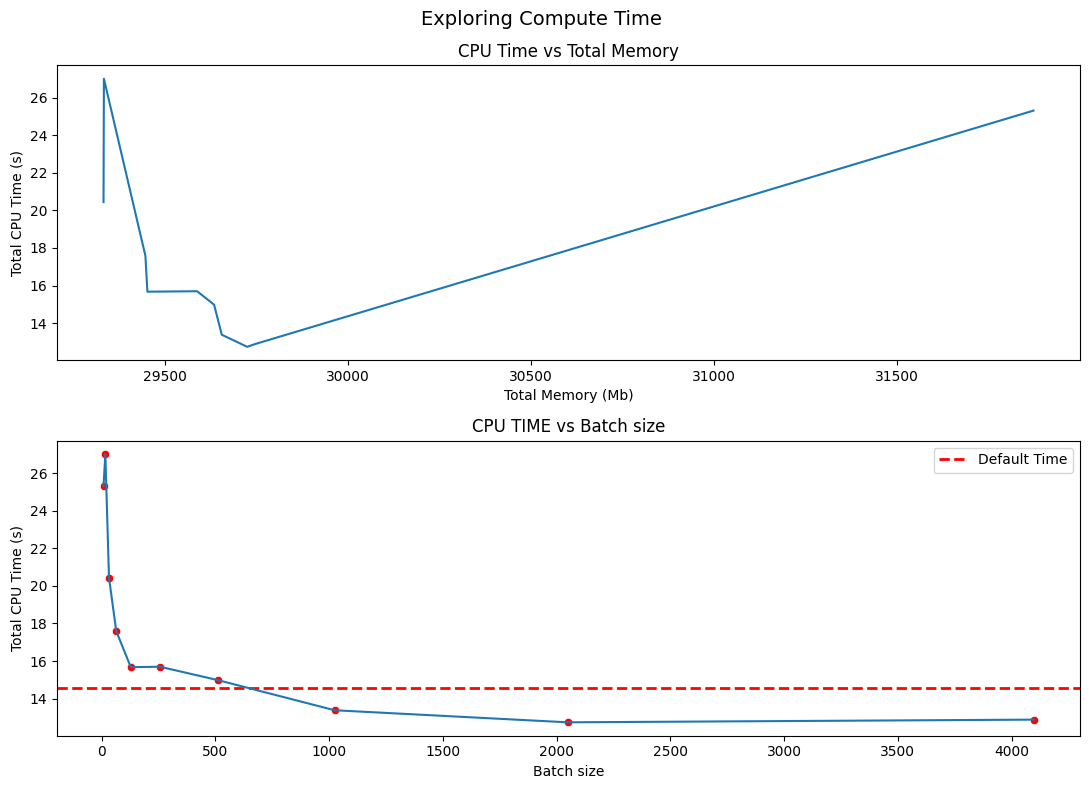

In [10]:
fig, ax = plt.subplots(2, 1)

fig.suptitle('Exploring Compute Time ', fontsize=14)

sns.lineplot(data=df_baseline, x = "total_cpu_memory", y = "total_cpu_time", ax = ax[0]).set(title = "CPU Time vs Total Memory", xlabel = "Total Memory (Mb)", ylabel ="Total CPU Time (s)")
plt.axhline(y=14.56, color='red', linestyle='--', linewidth=2, label='Default Time')

sns.lineplot(data=df_baseline, x = "batch_size", y = "total_cpu_time",ax = ax[1]).set(title = "CPU TIME vs Batch size", xlabel = "Batch size", ylabel ="Total CPU Time (s)")
sns.scatterplot(data=df_baseline, x='batch_size', y='total_cpu_time', ax=ax[1], color='red')
plt.axhline(y=14.56, color='orange', linestyle='--', linewidth=0.1,alpha=0.5, label='Default Time')

plt.tight_layout()
plt.show()

***

* Increasing the Batch size increases the memory used but also slows down the computer time for an inference.
* if rerun there will be some variability in the baseline

## Vary Model Size of the Data

* for ease right now keep the same size of the batch can vary depending on runtime.
* same data as the training data, don't expect model performance to change
* here we simulate different sizes of the training data [1G, 3G,5G, 10G, 13G], reminder the default read is for a model of 15 MB

In [11]:
# might need to run notebook 99_load_data.ipynb (can take between 1- 6 hours depending on connection)

!du -h ..//data/raw/cosmic_data

 13G	..//data/raw/cosmic_data/100MB
8.5G	..//data/raw/cosmic_data/10MB
 21G	..//data/raw/cosmic_data


In [12]:
# each of the tensors is some the size as listed on the directory
!du -h ..//data/raw/cosmic_data/10MB/10.pt
!du -h ..//data/raw/cosmic_data/100MB/10.pt

# example matching
!ls ..//data/raw/cosmic_data/100MB/{1..10}.pt

 10M	..//data/raw/cosmic_data/10MB/10.pt
100M	..//data/raw/cosmic_data/100MB/10.pt
..//data/raw/cosmic_data/100MB/1.pt  ..//data/raw/cosmic_data/100MB/5.pt
..//data/raw/cosmic_data/100MB/10.pt ..//data/raw/cosmic_data/100MB/6.pt
..//data/raw/cosmic_data/100MB/2.pt  ..//data/raw/cosmic_data/100MB/7.pt
..//data/raw/cosmic_data/100MB/3.pt  ..//data/raw/cosmic_data/100MB/8.pt
..//data/raw/cosmic_data/100MB/4.pt  ..//data/raw/cosmic_data/100MB/9.pt


In [13]:
!mkdir -p ..//data/raw/cosmic_data/large_files

!cat ..//data/raw/cosmic_data/100MB/{1..10}.pt > ..//data/raw/cosmic_data/large_files/01_gb.pt
!cat ..//data/raw/cosmic_data/100MB/{1..30}.pt > ..//data/raw/cosmic_data/large_files/03_gb.pt
!cat ..//data/raw/cosmic_data/100MB/{1..50}.pt > ..//data/raw/cosmic_data/large_files/05_gb.pt
!cat ..//data/raw/cosmic_data/100MB/{1..100}.pt > ..//data/raw/cosmic_data/large_files/10_gb.pt
!cat ..//data/raw/cosmic_data/100MB/*.pt > ..//data/raw/cosmic_data/large_files/13_gb.pt


In [14]:
#roughly there -- showing file sizes
!du -h ..//data/raw/cosmic_data/large_files/*

1.0G	..//data/raw/cosmic_data/large_files/01_gb.pt
2.9G	..//data/raw/cosmic_data/large_files/03_gb.pt
4.9G	..//data/raw/cosmic_data/large_files/05_gb.pt
9.8G	..//data/raw/cosmic_data/large_files/10_gb.pt
 13G	..//data/raw/cosmic_data/large_files/13_gb.pt


In [15]:
paths_ = glob("..//data/raw/cosmic_data/large_files/*.pt") # order isn't a guarantee here but it should be ordered
runtimes_ = []


for path in paths_:
    print(f"running path -- {path}")
    cosmic.set_data_path(path)
    cosmic.load_data()
    results = cosmic.run_inference()
    runtimes_.append(results)

df_baseline = get_reporting_table(runtimes_, "baseline_vary_datasizes")
df_baseline = df_baseline.assign(file_run = paths_)
df_baseline.to_csv("..//data/interim/baseline_vary_datasizes_with_filesize.csv", index=False)

df_baseline

running path -- ..//data/raw/cosmic_data/large_files/13_gb.pt
loading data from - ..//data/raw/cosmic_data/large_files/13_gb.pt
running path -- ..//data/raw/cosmic_data/large_files/10_gb.pt
loading data from - ..//data/raw/cosmic_data/large_files/10_gb.pt
running path -- ..//data/raw/cosmic_data/large_files/03_gb.pt
loading data from - ..//data/raw/cosmic_data/large_files/03_gb.pt
running path -- ..//data/raw/cosmic_data/large_files/01_gb.pt
loading data from - ..//data/raw/cosmic_data/large_files/01_gb.pt
running path -- ..//data/raw/cosmic_data/large_files/05_gb.pt
loading data from - ..//data/raw/cosmic_data/large_files/05_gb.pt


,total_cpu_time,total_cpu_memory,execution_time_per_batch,num_batches,batch_size,device,throughput_bps,throughput_mbps,file_run
0,45.74,121483.85,22.87,2,4096,cpu,18351684.19,18.35,..//data/raw/cosmic_data/large_files/13_gb.pt
1,45.49,121468.37,22.75,2,4096,cpu,18450154.28,18.45,..//data/raw/cosmic_data/large_files/10_gb.pt
2,45.44,121477.72,22.72,2,4096,cpu,18473256.41,18.47,..//data/raw/cosmic_data/large_files/03_gb.pt
3,44.98,121493.63,22.49,2,4096,cpu,18660294.89,18.66,..//data/raw/cosmic_data/large_files/01_gb.pt
4,45.00,121557.24,22.50,2,4096,cpu,18651403.83,18.65,..//data/raw/cosmic_data/large_files/05_gb.pt


In [16]:
# clean up
!rm -rf ..//data/raw/cosmic_data/large_files

In [17]:
# TODO add plots for these